# Introduction

This tutorial is going to demonstrate the dynamic bandit tree search for machinery fault diagnosis. 

## Data 

 We are going to use the well-known [CWRU Bearing Dataset](https://engineering.case.edu/bearingdatacenter).
 
In particular, an outer race fault data belonging to the [12k Drive End Bearing Fault](https://engineering.case.edu/bearingdatacenter/12k-drive-end-bearing-fault-data) is used. 

# DBTS for Fault Diagnosis

## import packages

In [1]:
## ----- standard packages
import numpy as np
import time
import os
import matplotlib.pyplot as plt

#---- dbtree packages
#-- load the multi_tree class
from dbtpy.dbtrees.multi_tree import BanditTreeSearch as BTS
#-- for saving & reading files
from dbtpy.tools.file_tools import get_time, save_dict, read_dict
#-- for visualizations 
from dbtpy.tools.visual_tools import show_ses, plot_ffts, plot_shape
from dbtpy.filters.meyerpy import meyer
from dbtpy.findexes.sigto import  sig_real_to_ses
#-- the data set 
from dbtpy.data.CWRU.cwru_data import CWRU_Data 
#-- objective function and fault harmonic evaluations
from dbtpy.funs.fun_diag import Diagnosis as Diag
from dbtpy.findexes.harmonics import harEstimation, vanillaSNR, harkurtosis, CHNR


## Define the Objective Function

In [2]:
##########################################################################
#--------------- the objective function for fault diagnosis
# ---------------------------- CWRU_Dat -----------------------------------
data = CWRU_Data()
sig_kargs={}
sig_kargs['fault_str'] = '147.mat' # file name 
sig_kargs['fs'] = 12e3 # sampling frequency 
sig_kargs['position'] = 'DE' # drive end bearing 
sig_kargs['resolution'] = 1 # frequency resolution 
sig_kargs['path'] = r'dbtpy\data\CWRU\data files'
sig = data.load(**sig_kargs)
##########################################################################
#--- meyer3_dbt fitler bounds
# all lower/upper bounds in a tuple
minB =   data.f_target * 3
blower = (minB, 2*minB) # lower bound
bupper = (data.fs / 2 - 2*minB, data.fs/2 - minB) # upper bound
##########################################################################
#-- define keywords arguments
# filter key words arguments
filter_kwargs={'filterBase':'meyer', 'filter_num':3}
# fault index key words arguments
findex_kwargs={'findexBase':'CHNR', 
                'sigD':'ses',
                 'fs': data.fs,
                 'f_target':data.f_target,
                 'dev1': 0.05
                  }
# #diagnosis key words arguments
diag_kwargs={'minB':minB}
#-- diagnosis objective function
diag = Diag(sig= sig, fs = data.fs, filter_kwargs = filter_kwargs, 
            findex_kwargs=findex_kwargs, diag_kwargs = diag_kwargs)
##########################################################################
#-- objective function for the optimization algorithm
obj_str = diag.filter_name  + '_' + diag.findex_name
obj_dict = {}
#------------------- meyer3 + CHNR
obj_dict[obj_str] = {'obj_fun':diag.meyer3_dbt,
                     'vars_and_bounds':{'b':[blower, bupper], 'dim':2},
                     'opt_mode':'max'}                 


## Important Information

In [3]:
##########################################################################
#--- Information of DBTS that you may want to save
path=r'tutorial\multi_tree_diag' 
#--------------------------------------------------------------------------
#--- file info. 
alg_save_dict = {}
alg_save_dict['alg_name'] = 'dbtree_multi_ts3_'+ obj_str
alg_save_dict['save_path'] =  path
alg_save_dict['sig_path'] = sig_kargs['path']
alg_save_dict['save_fileName'] = {}
alg_save_dict['save_fileName']['dict'] ='dict_'+ alg_save_dict['alg_name']  +'_'+ get_time() + '.txt'
alg_save_dict['save_fileName']['ses'] = 'ses_'+alg_save_dict['alg_name']  +'_'+ get_time() + '.png'
alg_save_dict['save_fileName']['tree'] = 'tree'+alg_save_dict['alg_name'] +'_'+ get_time() + '.png'
alg_save_dict['save_fileName']['ffts'] = 'ffts'+alg_save_dict['alg_name']  +'_'+ get_time() + '.png'
#--------------------------------------------------------------------------
#--- tree parameters
alg_save_dict['exp_rep_num'] = 1 # the number of repetitive experiments 
alg_save_dict['tree_depth'] = int(np.log2(len(sig)/2)) # automatic determination of the tree depth
alg_save_dict['solver_type'] = 'ts3' # multi-tree with the reshaped Thompson sampling
alg_save_dict['epoch_num'] = 100 # normally, 100-1000 is enough (also dependant on the allowed runing time)
#--------------------------------------------------------------------------
#--- optimization info.
alg_save_dict['opt_info'] = { obj:{'full_try_info':[],'full_opt_info':[],
                                   'obj_info':[], 'obj_mean_end':[],'obj_mean_list':[],
                                   'obj_std_end':[], 'obj_std_list':[], 
                                   'obj_median_end':[], 'obj_median_list':[] } for obj in obj_dict}

alg_save_dict['run_time'] = { obj:{'time_list':[], 'time_mean':[]}  for obj in obj_dict}

alg_save_dict['tree_shape'] = { obj:[]  for obj in obj_dict}
alg_save_dict['sig_opt'] = { obj:[]  for obj in obj_dict} # the optimal signal 
alg_save_dict['sig_opt_mfb'] = { obj:[]  for obj in obj_dict} # the actual boundaries of the optimal signal

## Run the Algorithm

In [4]:
#--------------------------------------------------------------------------
# create search algorithm
bts = BTS(alg_save_dict['tree_depth'])

###########################################################################
#-- run opt exp
for i in range(alg_save_dict['exp_rep_num'] ):
    #-- clear the records of the previous experiment
    diag.findex_opt = []
    diag.sig_opt = [] #

    for j, obj_str in enumerate(obj_dict):

        time_start=time.time()
        #-- run maximization
        bts.solve(solver_type = alg_save_dict['solver_type'],
                     epoch_num = alg_save_dict['epoch_num'] , 
                            **obj_dict[obj_str]) # **unpack

        time_end=time.time()
        alg_save_dict['sig_opt'][obj_str].append(diag.sig_opt.tolist())
        alg_save_dict['sig_opt_mfb'][obj_str].append(diag.sig_opt_mfb.tolist())
        alg_save_dict['tree_shape'][obj_str].append(bts.tree_shape()) 
        alg_save_dict['run_time'][obj_str]['time_list'].append(time_end - time_start)
        alg_save_dict['opt_info'][obj_str]['full_opt_info'].append(bts.var_opt_list)
        alg_save_dict['opt_info'][obj_str]['full_try_info'].append(bts.var_try_list)
        alg_save_dict['opt_info'][obj_str]['obj_info'].append([opt['objValue'] for opt in bts.var_opt_list])

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:09<00:00, 10.51it/s]

The Optimal =  {'b0': 3147.749347917968, 'b1': 2832.5959267138583, 'objValue': 0.4681479419523296} 



## Data Process and Save

In [5]:
###########################################################################
#-- simple data process
alg_save_dict['run_time'][obj_str]['time_mean'] = np.mean(alg_save_dict['run_time'][obj_str]['time_list'])
for obj_str in obj_dict:
    objValues = np.array(alg_save_dict['opt_info'][obj_str]['obj_info'])
    # objValues = objValues[:,:int(alg_save_dict['epoch_num'] * alg_save_dict['swarm_num'])]
    alg_save_dict['opt_info'][obj_str]['obj_mean_list'] = list(np.mean(objValues, axis = 0))
    alg_save_dict['opt_info'][obj_str]['obj_mean_end'] = alg_save_dict['opt_info'][obj_str]['obj_mean_list'][-1]
    alg_save_dict['opt_info'][obj_str]['obj_std_list'] = list(np.std(objValues, axis = 0))
    alg_save_dict['opt_info'][obj_str]['obj_std_end'] = alg_save_dict['opt_info'][obj_str]['obj_std_list'][-1]
    # alg_save_dict['opt_info'][obj_str]['obj_median_list'] = list(np.median(objValues, axis = 0))
    # alg_save_dict['opt_info'][obj_str]['obj_median_end'] = alg_save_dict['opt_info'][obj_str]['obj_median_list'][-1]

###########################################################################
#-- data save
savePath = os.path.join(alg_save_dict['save_path'], alg_save_dict['save_fileName']['dict'])
save_dict(alg_save_dict,  savePath)

## Visualization 

### Show the Optimal Signal in the FFT Spectrum

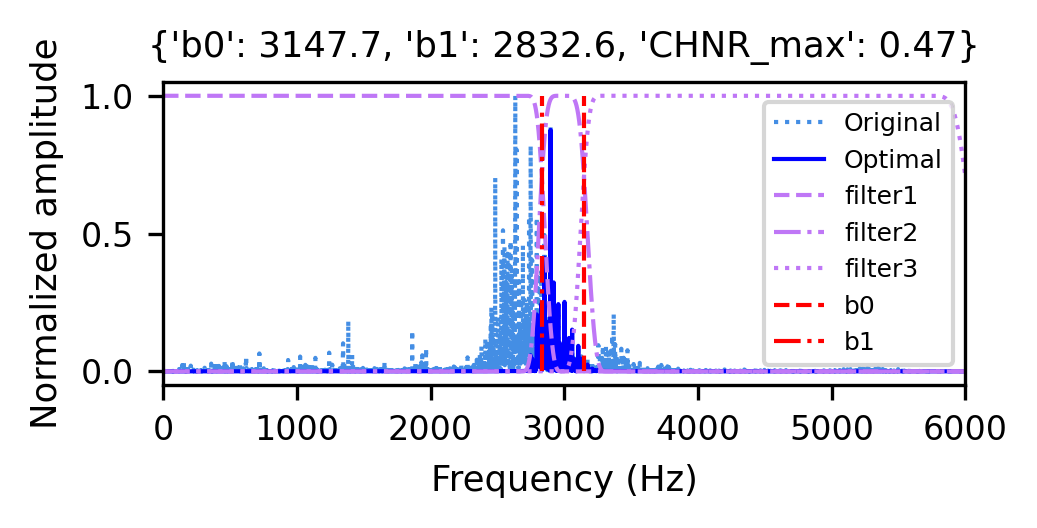

In [6]:
################################################################################
#----------------------------- optimization based 
#----- dbtree
sig_name = 'sig_opt'
dict_read = read_dict(savePath)
#-- get the demodulation spectrum signal
sig_out= np.array(list(dict_read[sig_name].values())).squeeze()
ses = sig_real_to_ses(sig_out)

#-- fftspectrum
#--------------------------------------------------------------------------
#-- comparasion of the original and the optimal 
exp_ind = -1 # the experiment index in the repetitive experiments 
sig_opt = dict_read['sig_opt'][obj_str][exp_ind]
sig_opt_mfb = np.array(dict_read['sig_opt_mfb'][obj_str][exp_ind])

#-- keep some digits
opt_dict = {}
opt_dict_copy = dict_read['opt_info'][obj_str]['full_opt_info'][exp_ind][-1]
opt_dict['b0'] = round(opt_dict_copy['b0'], 1)
opt_dict['b1'] = round(opt_dict_copy['b1'], 1)
opt_dict['CHNR_max'] =  round(opt_dict_copy['objValue'], 2)

#-- the bounaries tried by dbtree 
bounds = np.array([opt_dict['b0'], opt_dict['b1']]) 
plt.close('all')
#-- hightlight optimal band
plot_ffts(sig, sig_opt, opt_dict, fs = data.fs, dpi=300, mfb=sig_opt_mfb, boundaries=bounds)


Note that the boundaries b0 and b1 can disagree with the actual filer boundaries of filter1 and filter2. It just means that the bandwidth constraints are violated. 

### Show the Squared Envelope Spectrum 

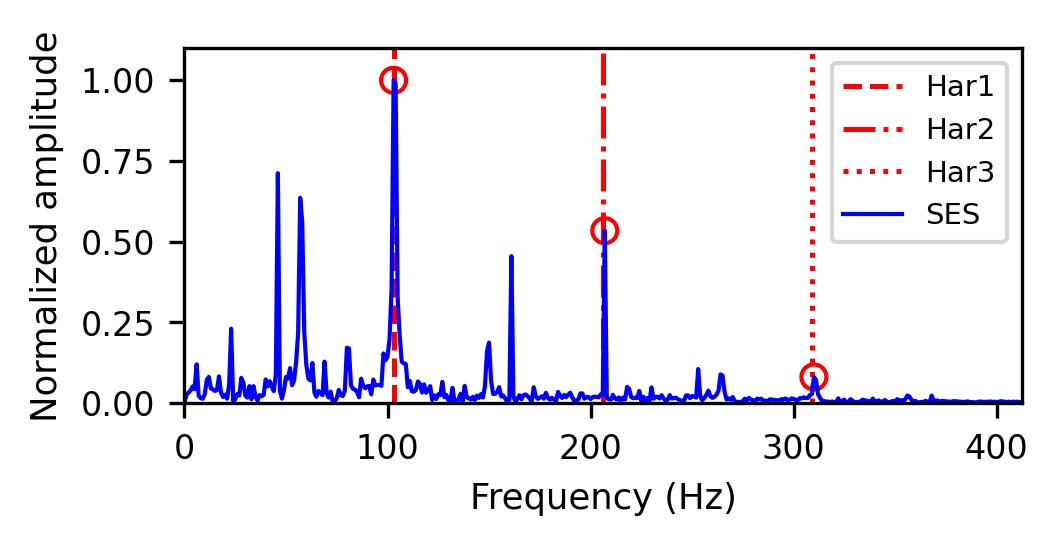

In [8]:
#-- for harmonic estimation
dev1 = 0.05
#-- ses
show_ses(sig_real = sig_out,fs=data.fs, SSES=False, dpi=300,  dev1 = dev1 ,
          f_target=data.f_target,sig_len_original=len(sig_out))


### Show the Tree Shapes

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2474.79it/s]


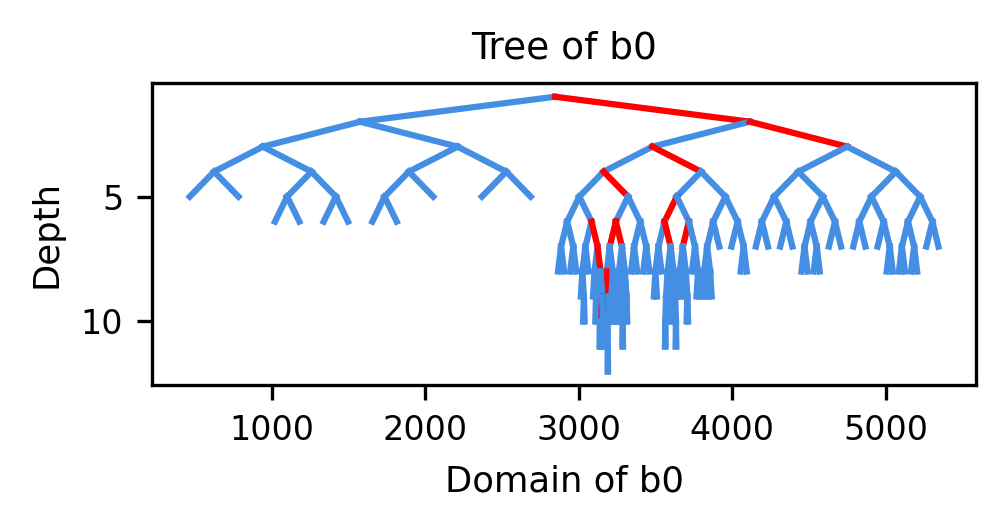

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2506.19it/s]


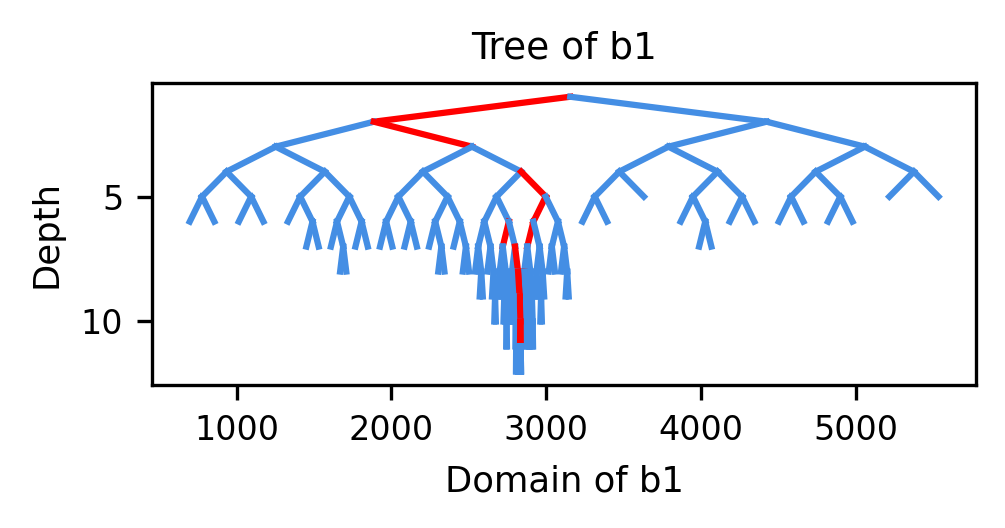

In [9]:
# #-- tree
bran_dict = dict_read['tree_shape'][obj_str][-1]
for tree in bran_dict:
    plot_shape(branches_list = bran_dict[tree] , treeID = tree, dpi=300,
                s_color = 'red', f_color = 'xkcd:dark sky blue')

## Quantitative Analysis

In [10]:
# ###############################################################################
#------------------------------ quantative analysis
#------------------------------ We consider the first three fault harmonics in the normalized SES
#-- the mean amplitude 
A_amps, _ = harEstimation(seq=ses,f_target=data.f_target, harN = 3, fs=data.fs, dev1 = dev1, 
                   sig_len_original=len(sig_out))
A_amps_norm = A_amps / max(ses)
A_mean_amp = np.mean(A_amps_norm)

#-- the vanilla signal to noise ratio
A_vanSNR = vanillaSNR(seq=ses,f_target=data.f_target, harN = 3, fs=data.fs, dev1 = dev1, 
                   sig_len_original=len(sig_out))
#-- the harmonic kurtosis 
A_harkurt = harkurtosis(seq=ses,f_target=data.f_target, harN = 3, fs=data.fs, dev1 = dev1, 
                   sig_len_original=len(sig_out))
#-- the cyclic harmonic to noise ratio 
A_chnr=CHNR(seq=ses,f_target=data.f_target, harN = 3, fs=data.fs, dev1 = dev1, 
                   sig_len_original=len(sig_out))

print('\n')
print('run_time = ', round(dict_read['run_time'][obj_str]['time_mean'], 2), ' s')
print('mean amplitude = ', round(A_mean_amp, 2))
print('vanilla SNR = ', round(A_vanSNR, 2))
print('harmonic kurt = ', round(A_harkurt, 2))
print('CHNR = ', round(A_chnr, 2))
# ###############################################################################



run_time =  9.5  s
mean amplitude =  0.54
vanilla SNR =  -8.86
harmonic kurt =  25.15
CHNR =  0.47
